### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 4
### Due: Friday, Feb 21st at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [119]:
import numpy as np
import scipy
import scipy.stats
from matplotlib import pyplot as plt
import matplotlib

# --------------------------------------------------------------------------
# PART 1

# Voltage measurements, but NOT A FUNCTION OF TIME. 

Volt_data = np.load('/Users/katiebarnhart/Documents/hw4_data_1.npy')
#print(Volt_data)
M_data = []
for i in Volt_data:
    M_data.append(i[0])
Uncert_data = []
for j in Volt_data:
    Uncert_data.append(j[1])

M_data = np.array(M_data)
Uncert_data = np.array(Uncert_data)

mean = np.sum(M_data/(Uncert_data**2)) / np.sum(1/Uncert_data**2)
stnd_error = 1 / (np.sqrt(np.sum(1/Uncert_data**2)))
print('the mean is', mean, 'and the standard error is', stnd_error)

# --------------------------------------------------------------------------
# PART 2

def Ln_likelihood(measurements, uncertainties, mu):
    numerator = np.log(2 * np.pi * uncertainties**2) + (measurements - mu)**2
    denominator = 2 * uncertainties**2
    calculation = len(M_data) * np.sum(numerator/denominator) 
    return calculation

#optimization stuff 

f_part2 = lambda mean: Ln_likelihood(M_data, Uncert_data, mean)
BF_meanV = scipy.optimize.fmin(f_part2, 2)

print("output:", type(BF_meanV), "The bestfit mean voltage is:", BF_meanV[0])



the mean is 4.942118214425304 and the standard error is 0.43024334605205083
Optimization terminated successfully.
         Current function value: 89.592002
         Iterations: 19
         Function evaluations: 38
output: <class 'numpy.ndarray'> The bestfit mean voltage is: 4.942089843750006


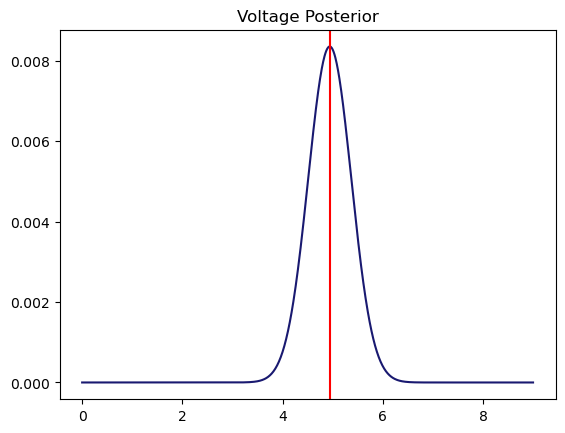

In [120]:
# --------------------------------------------------------------------------
# PART 3

# posterior probability density
pt2_bestfit = 4.942 #mu. value. note to self. 

""" testing stuff
print(M_data)
test1 = M_data * 2.0
print(test1)
test2 = np.prod(M_data)
print(test2)
"""

def pt3_likelihood(measurements, uncertainties, mu):
    total = []
    for i in range(len(measurements)):
        part = (1/(np.sqrt(2*np.pi*(uncertainties[i])**2))) * np.exp(-((measurements[i] - mu)**2) / (2*(uncertainties[i]**2)))
        #print(part)
        total.append(part)
        
    return np.prod(total)

# test call pt3_likelihood(M_data, Uncert_data, pt2_bestfit)
xgrid = np.linspace(0, 9, 1000)
#we need a uniform prior from 3 to 7
prior = []
for j in xgrid:
    if j >= 3.0 and j <= 7.0:
        prior.append(0.5)
    else:
        prior.append(0)

poste = []
for i in range(1000):
    poste.append(pt3_likelihood(M_data, Uncert_data, xgrid[i]) * prior[i])

normed_poste = poste / np.sum(poste) #normalized

fig = plt.plot(xgrid, normed_poste, color='midnightblue')
plt.title('Voltage Posterior')
plt.axvline(BF_meanV[0], color = 'red')


The 68.3% confidence interval for the mean ranges from 4.511570355143607 to 5.372609332356405
Whereas the sample mean -/+ the standard error is: 4.511874868373253 and 5.372361560477355
Not a huge difference!
The MAP is 4.945945945945946


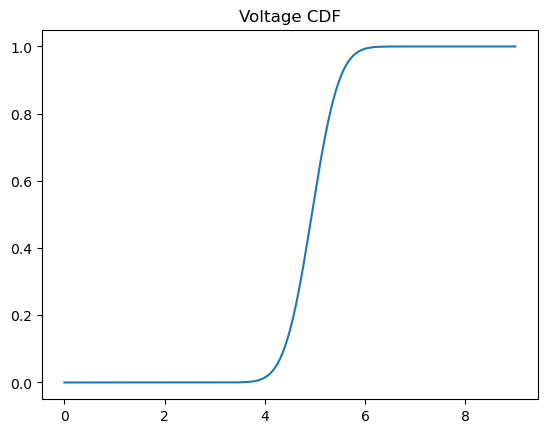

In [121]:
# --------------------------------------------------------------------------
# PART 4

CDF = np.cumsum(normed_poste) / np.sum(normed_poste)
fig = plt.plot(xgrid, CDF)
plt.title('Voltage CDF')

# 68.3% confidence intervals
#print(type(normed_poste))
confidence_68 = scipy.stats.norm.interval(0.683, BF_meanV[0], stnd_error)
print("The 68.3% confidence interval for the mean ranges from", confidence_68[0], "to", confidence_68[1])
print("Whereas the sample mean -/+ the standard error is:", mean-stnd_error, "and", mean+stnd_error)
print("Not a huge difference!")

# MAP value of the mean
arg = np.argmax(normed_poste) # Thank you stack exchange for telling me that argmax exists
MAP = xgrid[arg]
print("The MAP is", MAP)

The 68.3% confidence interval for the mean ranges from 4.511570355143607 to 5.372609332356405
Whereas the sample mean -/+ the standard error is: 4.511874868373253 and 5.372361560477355
The MAP is 4.945945945945946


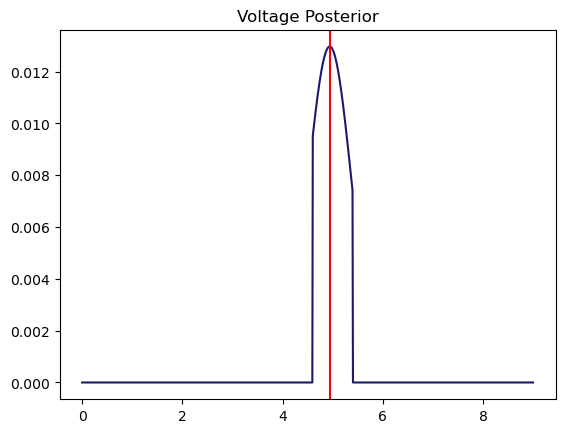

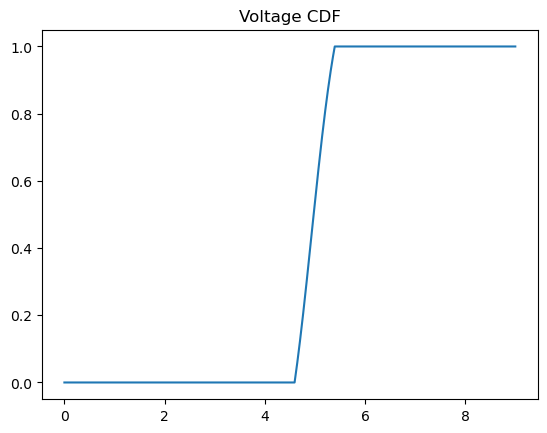

In [122]:
# --------------------------------------------------------------------------
# PART 5
xgrid2 = np.linspace(0, 9, 1000)
#we need a uniform prior, NOW from 4.6 to 5.4
prior2 = []
for j in xgrid2:
    if j >= 4.6 and j <= 5.4:
        prior2.append(0.5)
    else:
        prior2.append(0)

poste2 = []
for i in range(1000):
    poste2.append(pt3_likelihood(M_data, Uncert_data, xgrid2[i]) * prior2[i])

normed_poste2 = poste2 / np.sum(poste2) #normalized
fig1 = plt.figure()
plt.plot(xgrid2, normed_poste2, color='midnightblue')
plt.title('Voltage Posterior')
plt.axvline(BF_meanV[0], color = 'red')


CDF = np.cumsum(normed_poste2) / np.sum(normed_poste2)
fig2 = plt.figure()
plt.plot(xgrid2, CDF)
plt.title('Voltage CDF')

# 68.3% confidence intervals
#print(type(normed_poste))
confidence_682 = scipy.stats.norm.interval(0.683, BF_meanV[0], stnd_error)
print("The 68.3% confidence interval for the mean ranges from", confidence_68[0], "to", confidence_682[1])
print("Whereas the sample mean -/+ the standard error is:", mean-stnd_error, "and", mean+stnd_error)


# MAP value of the mean
arg2 = np.argmax(normed_poste2) # Thank you stack exchange for telling me that argmax exists
MAP2 = xgrid2[arg2]
print("The MAP is", MAP2)
# Why are those exactly the same? Did I miss changing a variable name somewhere?? I can't find it. 

<class 'scipy.stats._distn_infrastructure.rv_continuous_frozen'>
The 68.3% confidence interval for the mean ranges from 4.511570355143607 to 6.430519488606399
Whereas the sample mean -/+ the standard error is: 4.511874868373253 and 5.372361560477355
The MAP is 4.945945945945946


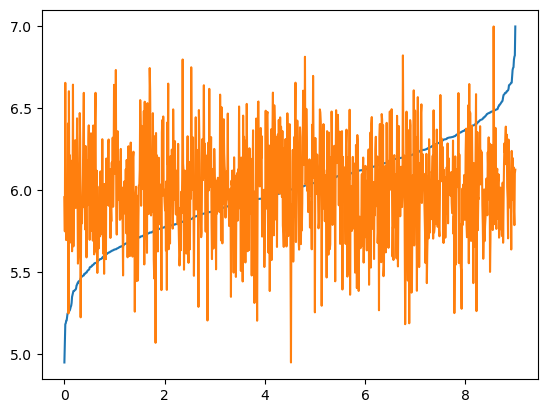

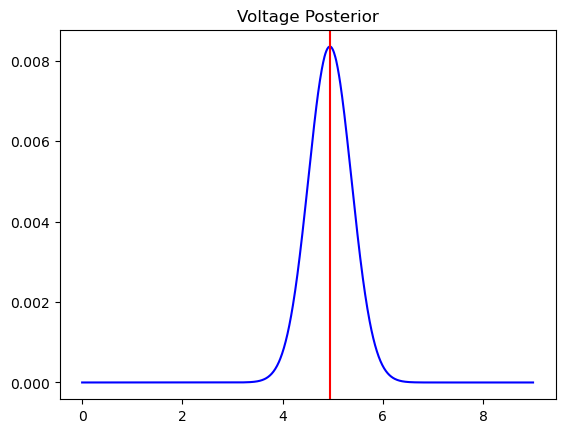

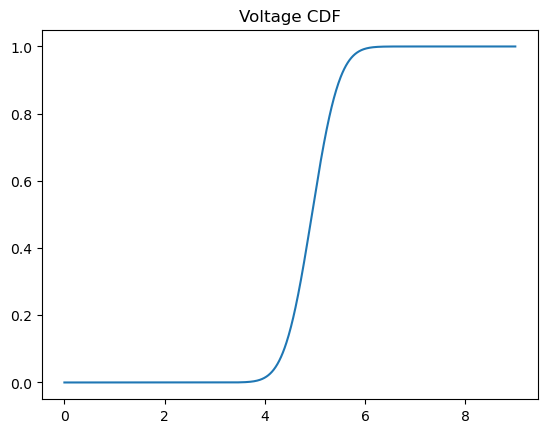

In [123]:
# --------------------------------------------------------------------------
# PART 6
# Note, something in here is wrong but I dont know what. Detail at the bottom of the cell. 

Gaussian_dist = scipy.stats.norm(6, 0.3)
print(type(Gaussian_dist))
draws = Gaussian_dist.rvs(1000)
discrete_G_prior = np.sort(draws)
#print(type(discrete_G_prior), discrete_G_prior)
fig1 = plt.figure()
plt.plot(xgrid6, discrete_G_prior)
plt.plot(xgrid6, draws)

xgrid6 = np.linspace(0, 9, 1000)
poste6 = []
for j in range(1000):
    poste6.append(pt3_likelihood(M_data, Uncert_data, xgrid6[j]) * discrete_G_prior[j])

normed_poste6 = poste6 / np.sum(poste6) #normalized
fig2 = plt.figure()
plt.plot(xgrid6, normed_poste6, color='blue')
plt.title('Voltage Posterior')
plt.axvline(BF_meanV[0], color = 'red')


CDF = np.cumsum(normed_poste6) / np.sum(normed_poste6)
fig3 = plt.figure()
plt.plot(xgrid6, CDF)
plt.title('Voltage CDF')

# 68.3% confidence intervals
#print(type(normed_poste))
confidence_686 = scipy.stats.norm.interval(0.683, 6, stnd_error)
print("The 68.3% confidence interval for the mean ranges from", confidence_68[0], "to", confidence_686[1])
print("Whereas the sample mean -/+ the standard error is:", mean-stnd_error, "and", mean+stnd_error) # this line is wrong


# MAP value of the mean
arg6 = np.argmax(normed_poste6)
MAP6 = xgrid6[arg6]
print("The MAP is", MAP6) 
#again this is exactly the same and that shouldn't be the case. 
#I'm using the right prior, so it isnt that. 
#I've tried programming in the prior at least 4 different ways, but I'm still getting this.
#I've checked the function call. It's fine. 
# something with the mean that gets passed to scipy.stats.norm.interval

Text(0, 0.5, 'PDFs, supposedly')

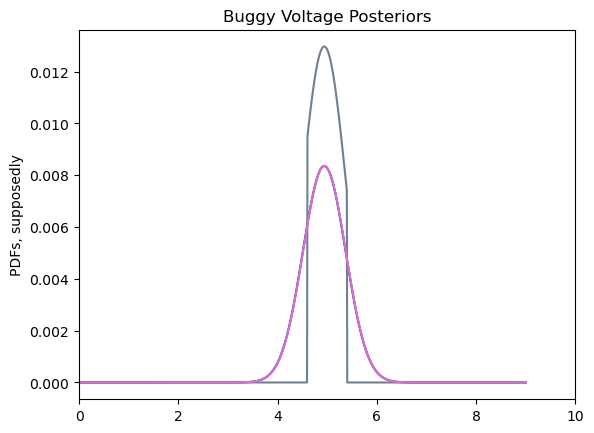

In [124]:
# --------------------------------------------------------------------------
# PART 7

# Due to the frustrating issues with prior parts of this HW, this cell is going to be hilariously unilluminating 

plt.plot(xgrid, normed_poste, color='midnightblue')
plt.plot(xgrid2, normed_poste2, color='slategrey')
plt.plot(xgrid6, normed_poste6, color='orchid')
plt.xlim(0, 10)
plt.title('Buggy Voltage Posteriors')
plt.ylabel("PDFs, supposedly")
# again, based on the different information in each prior, these should all be slightly different. They are not. 

In [125]:
# --------------------------------------------------------------------------
# PART 8
# Delta functions integrate to 1 when they are included in the integration region. 
# Isn't using a delta function for a prior kind of pointless?
# it's essentially saying 'we already know the value for whatever thing this is', is it not?
# I've heard the term 'improper prior' used before, but don't know what it means. Are these two things related at all? 

part3_evidence = np.sum(poste)

# scipy.integrate() seems to be more for numerical integration, and not for trying to define some weird variable
# I've never used scipy.integrate before. A classmate told me about it just this weekend 
# and I would love to be directed toward a notebook or some sort of lesson about it in order to understand what it does and how it can be used 

#print(xgrid[549])
prior8 = []
for j in range(1000):
    if j == 549:
        prior8.append(1) # buuuuut, a delta function is infinite at it's defined point. So this is wrong. 
    else:
        prior8.append(0)

poste8 = []
for i in range(1000):
    poste8.append(pt3_likelihood(M_data, Uncert_data, xgrid[i]) * prior8[i])

part8_evidence = np.sum(poste8)

print(part3_evidence, part8_evidence)
ratio = part3_evidence / part8_evidence
print(ratio, "some evidence that a uniform prior is favored") #that is, assuming that literally anything in this cell is reasonable. 


6.419955863668456e-06 1.0725546873438295e-07
59.856676208906514 some evidence that a uniform prior is favored


[[1, 1.92], [3, 1.17], [4, 1.55], [6, 1.38], [8, 1.6]]


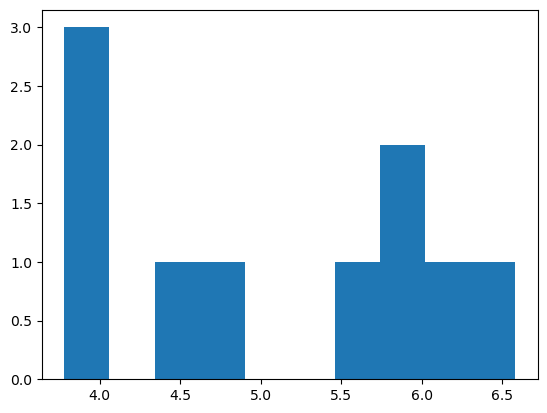

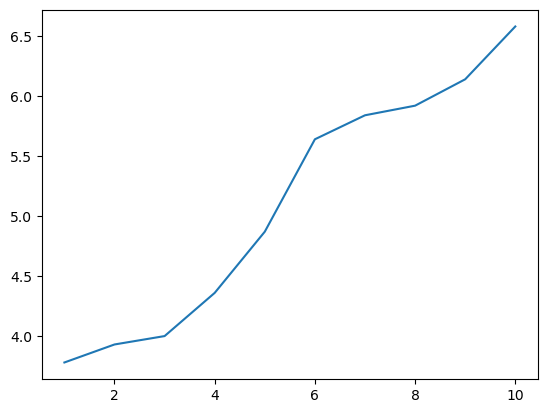

In [25]:
#cell for funzies only, not part of the HW
#I wanna plot the data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
fig1 = plt.figure()
plt.hist(M_data) #well that's gross looking
# print(type(M_data))

fig2 = plt.figure()
sorted_M_data = np.sort(M_data)
plt.plot(x, sorted_M_data)

# is there a way to / how can I "sort" a 2D array and make sure that the values that need to stay together DO stay together
test_array = [[6, 1.38], [1, 1.92], [3, 1.17], [8, 1.60], [4, 1.55]]
stest_array = sorted(test_array)
print(stest_array) # OKAY it's the sorted() function. 



## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

Text(0.5, 1.0, 'Un-Normalized PDF')

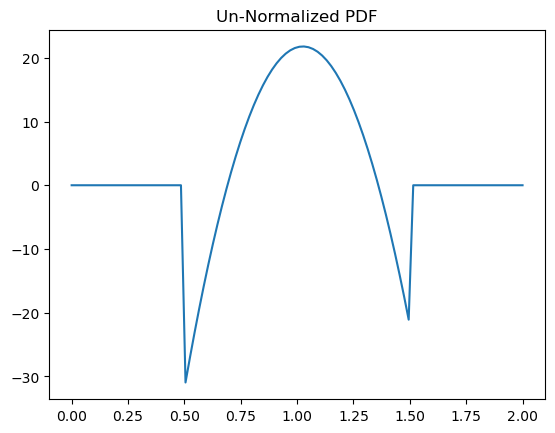

In [128]:
# --------------------------------------------------------------------------
# PARTS 1 and 2

x, y, sigma_y = np.load('/Users/katiebarnhart/Documents/hw4_data_2.npy')
# print('x is', x, 'y is', y, 'and the y uncerts are', sigma_y) 
# this seems to be homoscedastic


#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

xgrid20 = np.linspace(0, 2, 100)
#uniform prior from 0.5 to 1.5
prior20 = []
for j in xgrid20:
    if j >= 0.5 and j <= 1.5:
        prior20.append(1)
    else:
        prior20.append(0)

poste20 = []
for i in range(100):
    theta = [-0.23, xgrid20[i]]
    poste20.append(logL(theta, [x, y, sigma_y]) * prior20[i])

plt.plot(xgrid20, poste20) # this cursed plot be looking like ¯\_(ツ)_/¯
plt.title("Un-Normalized PDF")
# Im sorry. I tried. But I am, at this time, good enough at neither coding nor statistics to know how to go about fixing this. 

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

In [114]:
# --------------------------------------------------------------------------
# PART 3

evidence = np.sum(poste)
print(evidence)

255.70219186773204


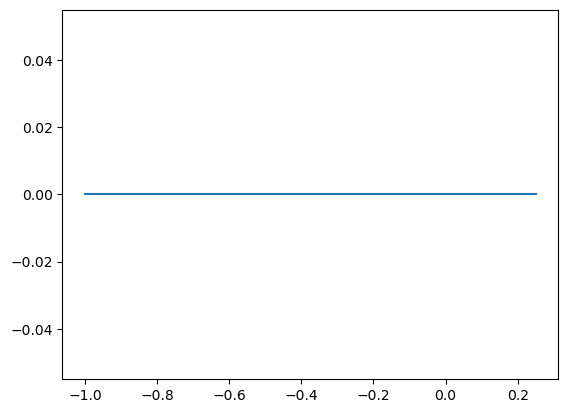

In [132]:
# --------------------------------------------------------------------------
# PART 4

xgrid24 = np.linspace(-1, 0.25, 100)
prior24 = []
for j in xgrid24:
    if j >= 0.5 and j <= 1.5:
        prior24.append(1)
    else:
        prior24.append(0)


poste4 = []
for i in range(100):
    theta = [-0.23, xgrid24[i], 2]
    poste4.append(logL(theta, [x, y, sigma_y]) * prior24[i])

# just the second one 
plt.plot(xgrid24, poste4)
# again, clearly wrong. 
# The lecture 8 and lecture 9 notebooks use lots of different things for theta, and I feel like I'm missing and essential piece of info here that might help me actually solve this. 

In [ ]:
# The rest of this homework depends on having gotten the prior parts correct.